# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Subsampling images of fashion mnist

As we need to create a look up table we need to reduce the input neuron size. Thus, we will need to sample our images

In [236]:
#creating the sample indexes
skipsinIndexes = 3
if 28%skipsinIndexes==0:
    newShape = 28//skipsinIndexes
else:
    newShape = 28//skipsinIndexes + 1
Y, X = np.meshgrid([i for i in range(0, 28, skipsinIndexes)], [i for i in range(0, 28, skipsinIndexes)])
X, Y

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
        [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
        [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
        [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
        [21, 21, 21, 21, 21, 21, 21, 21, 21, 21],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]]),
 array([[ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
        [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27]

In [237]:
sampled_x_train = np.zeros(((newShape)**2, x_train.shape[1]))
sampled_x_val = np.zeros(((newShape)**2, x_val.shape[1]))
for i in range(x_train.shape[1]):
    samp = x_train[:, i].reshape((28, -1))
    sampled_x_train[:, i] = samp[X, Y].flatten()
for i in range(x_val.shape[1]):
    samp = x_val[:, i].reshape((28, -1))
    sampled_x_val[:, i] = samp[X, Y].flatten()

Text(0.5, 1.0, 'Subsampled version of the image with samples every 3 indices')

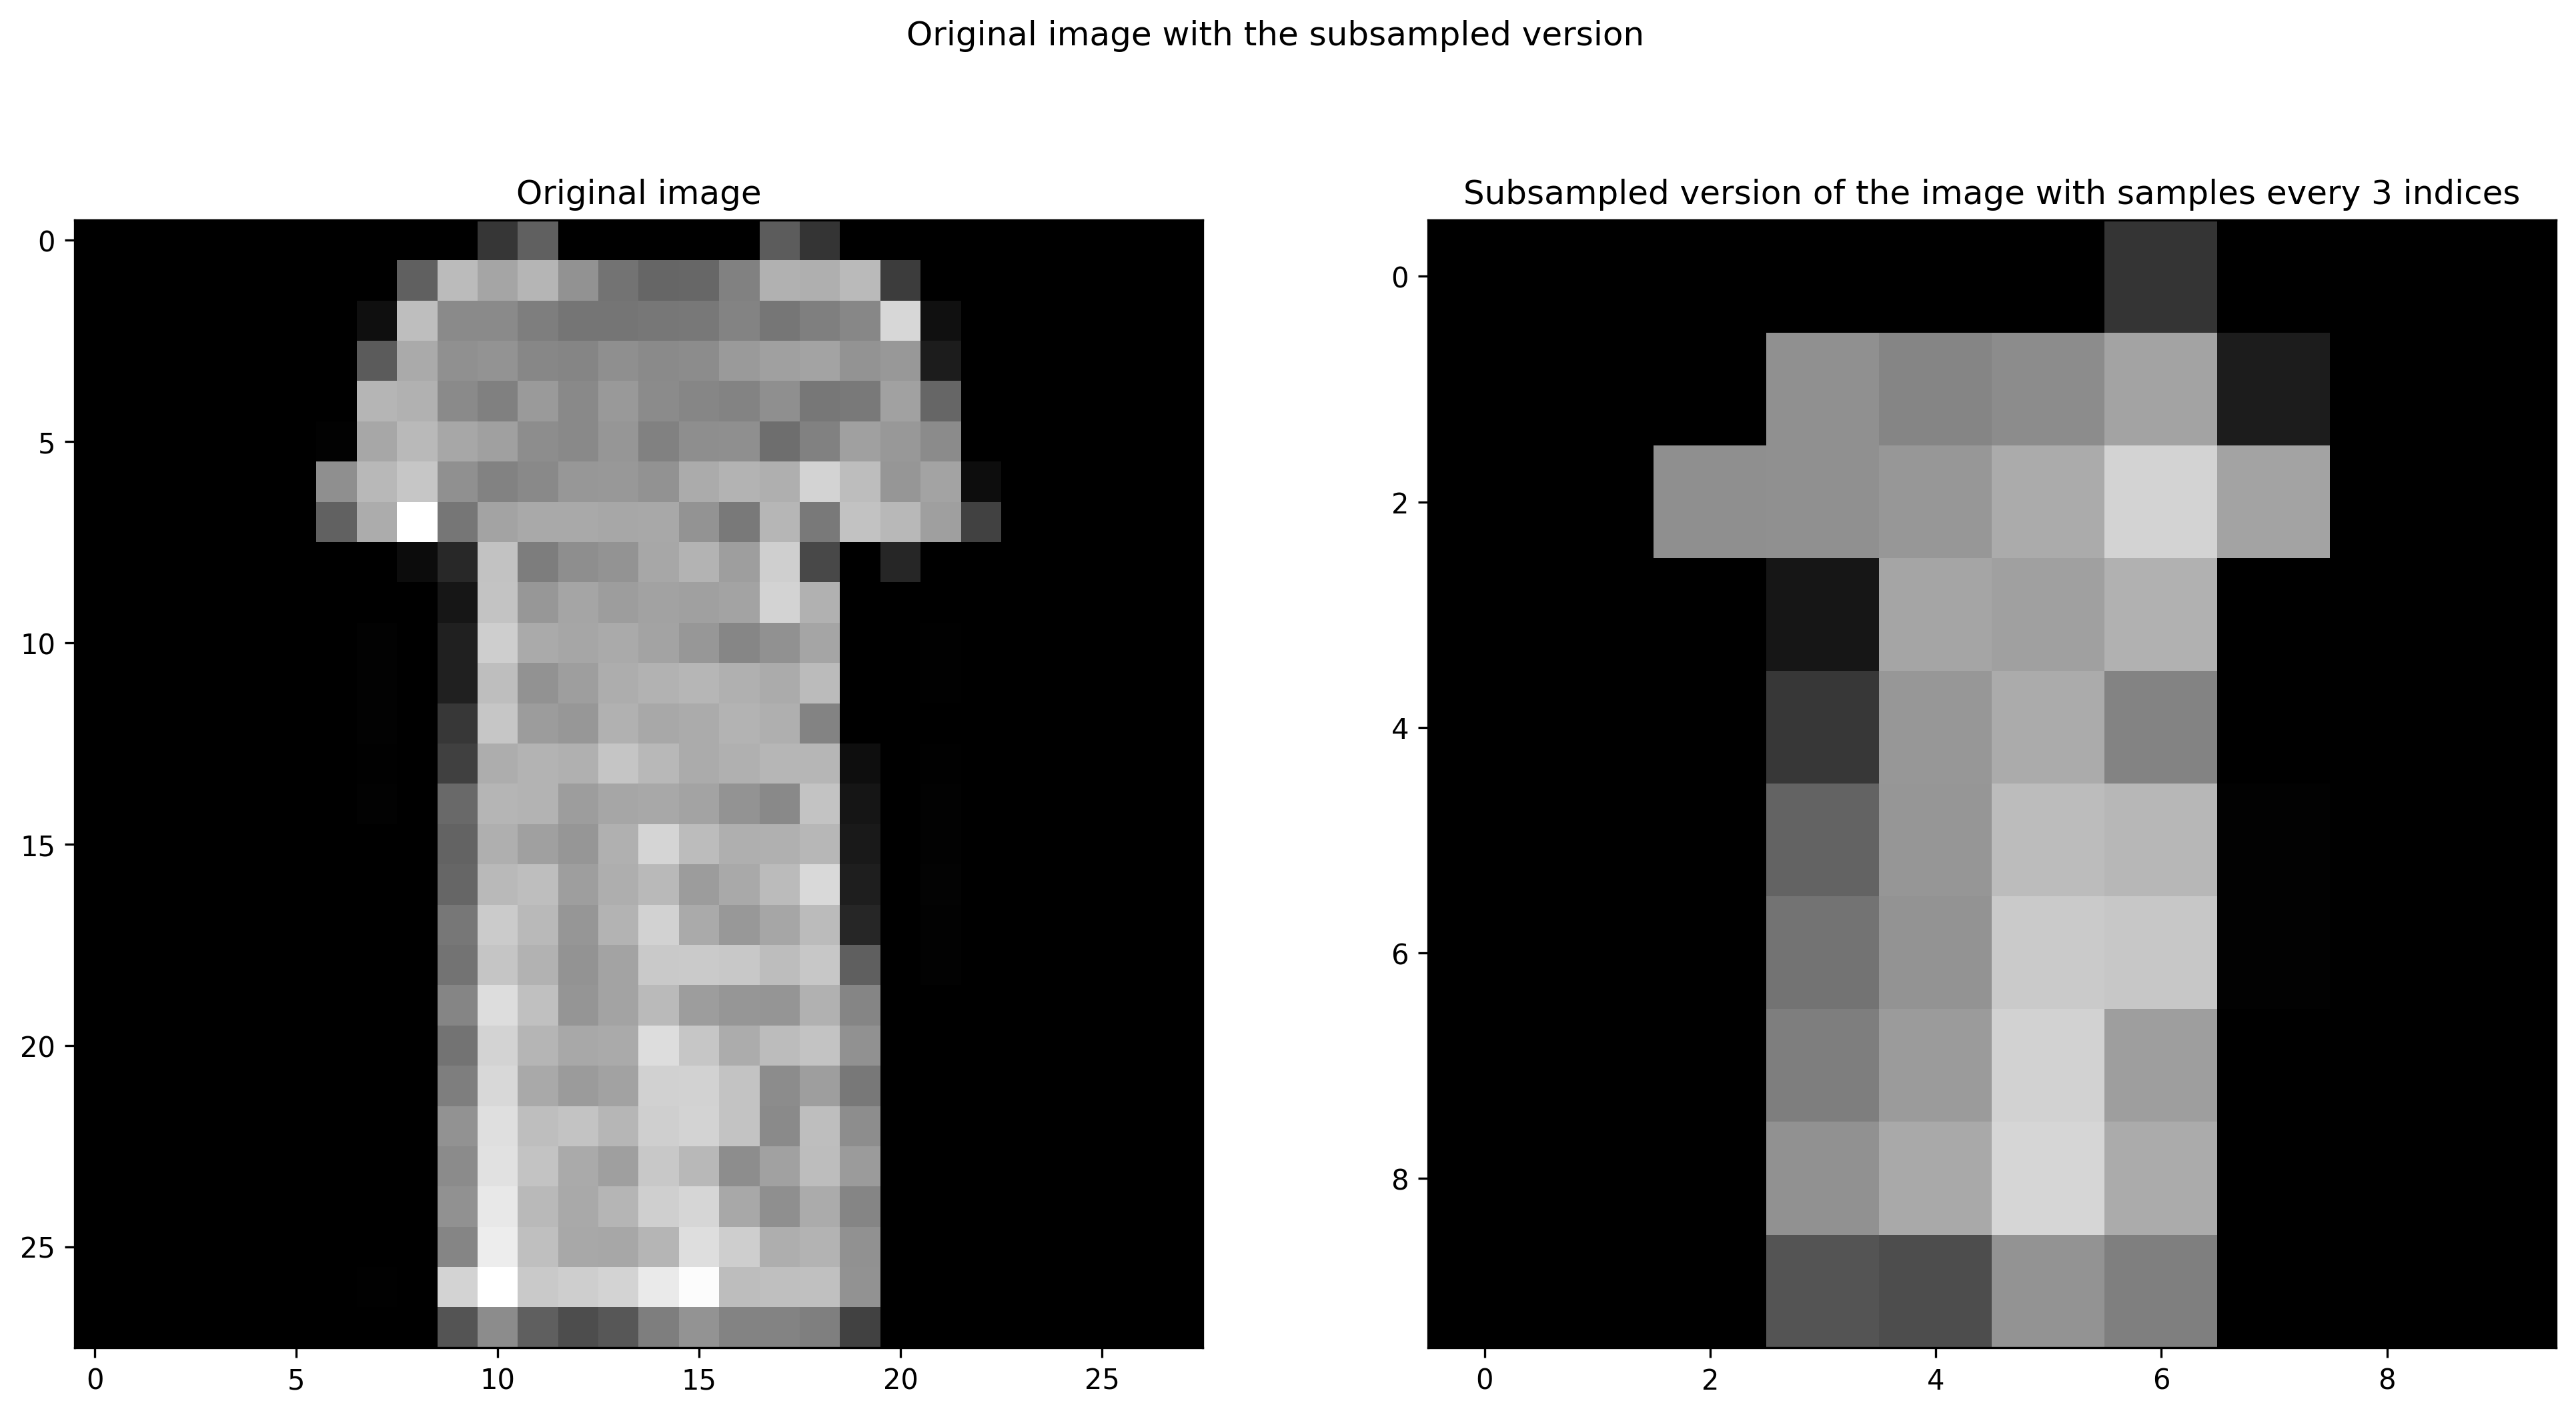

In [239]:
plt.figure(figsize = (16, 8))
plt.gcf().set_dpi(300)
ind = np.random.randint(0, x_train.shape[1])
plt.suptitle("Original image with the subsampled version")
plt.subplot(121)
plt.imshow(x_train[:, ind].reshape(28, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title("Original image")
plt.subplot(122)
plt.imshow(sampled_x_train[:, ind].reshape(newShape, -1), cmap = 'gray', vmin =0, vmax = 1)
plt.title(f"Subsampled version of the image with samples every {skipsinIndexes} indices")

# Training software BP with new subsampled version of MNIST

In [191]:
def params_init(newShape, midLayerSize, seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(midLayerSize,newShape) - 0.5
  b1 = np.random.rand(midLayerSize,1) - 0.5
  W2 = np.random.rand(10,midLayerSize) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [143]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [144]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10e-16)), axis = 0)
  return loss

In [145]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

In [146]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

In [147]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [211]:
def batch_grad_descent(X,Y,iter, lr, midLayerSize, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}
  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = None)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(sampled_x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score} Val loss: {np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      # plt.figure()
      # plt.hist(W1.flatten())

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [241]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(sampled_x_train,y_train,iter=200, lr=0.01,midLayerSize = 10, print_op=20);

Params Initialised
Iteration: 20
Train accuracy: 61.782539682539685
Val accuracy: 60.52857142857143 Val loss: 7428.307104420037
Iteration: 40
Train accuracy: 67.47777777777777
Val accuracy: 66.68571428571428 Val loss: 6146.390346636079
Iteration: 60
Train accuracy: 70.30952380952381
Val accuracy: 69.58571428571429 Val loss: 5660.585001546311
Iteration: 80
Train accuracy: 71.92063492063492
Val accuracy: 71.0 Val loss: 5378.421568093978
Iteration: 100
Train accuracy: 72.86825396825397
Val accuracy: 72.18571428571428 Val loss: 5184.358233221508
Iteration: 120
Train accuracy: 73.5904761904762
Val accuracy: 72.94285714285714 Val loss: 5039.1441718907545
Iteration: 140
Train accuracy: 74.17142857142856
Val accuracy: 73.71428571428571 Val loss: 4923.858450111568
Iteration: 160
Train accuracy: 74.66507936507936
Val accuracy: 74.3 Val loss: 4828.131067010661
Iteration: 180
Train accuracy: 75.10952380952382
Val accuracy: 74.8 Val loss: 4746.410202910088
Iteration: 200
Train accuracy: 75.45079365

### Generic functions related to variability

In [167]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [168]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    #Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [169]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [170]:
def createLookUpTable2d(weightArray, currents, precision, step, discreteSteps, wRange):
    dis = [(-1)*i for i in discreteSteps[::-1]] + discreteSteps
    finalLookUp = np.zeros((weightArray.shape[0], weightArray.shape[1], len(dis)))
    k = 0
    for i in dis:
        maskee = np.ones_like(weightArray, dtype = float)*i
        maskeeTransformed  = weightTransformWithVariability(maskee, currents, precision, step, discreteSteps, wRange)
        finalLookUp[:, :, k] += maskeeTransformed
        k +=1
    return finalLookUp 

In [263]:
def nearest(lookUpDiff, weightUpdate):
    # W1new = W1  - (lr*dW1)
    # we want to compare and find W1new such that |W1new-(W1  - (lr*dW1))| has least error!!!
    # We look at L1 error and take the minimum of this!
    idx = np.argmin(np.abs(lookUpDiff - weightUpdate[:,:,None]), axis = 2)
    return idx

In [172]:
def findNextWeight(lookUp, lookUpDiff, weightUpdate):
    idx = np.indices(nearest(lookUpDiff, weightUpdate).shape)
    #discrete lookup needs to be used
    return lookUp[idx[0],idx[1],nearest(lookUpDiff, weightUpdate)]

In [173]:
def findNextState(disArr, lookUpDiff, weightUpdate):
    return disArr[nearest(lookUpDiff, weightUpdate)]

## Verifying correctness of look up table code

In [333]:
mu = 0.7
sigma = 0.01
onoff = 10000
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 10
midLayerSize = 10
lr = 0.1

In [334]:
W1 = np.arange(-1, 1, 0.02).reshape((10,10))

In [335]:
disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff



W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)

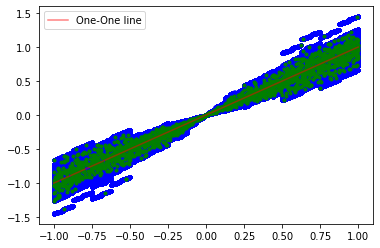

In [352]:
plt.figure()
for i in range(0, 10):
     for j in range(0, 10):
        plt.plot(disArr, W1lookUp[i, j, :], 'b.', alpha = 0.4)

for _ in range(20):
        W1rand = np.random.rand(10, 10)*2 - 1
        plt.plot(W1rand.flatten(), weightTransformWithVariability(W1rand, W1Currents, precision, step, discreteSteps, wRange).flatten(), 'g.')
plt.plot(disArr, disArr, 'r', alpha = 0.5, label = "One-One line")
plt.legend()

The blue dots demarcate the varibility transforms of the qauntized values for each SRAM cell, while the green dots signify randomly sampled weight arrays whose variability transforms are plotted.

We notice that the green dots just sample the blue dots. This is correct since random sampled values are first quantized i.e to a value lying in the quantized space and then variability transform is applied. This would be equivalent to sampling a value from the variability transforms of the quantized value of that particular SRAM cell.

Further, we also notice the "gaussianess" of our distributions. Green dots lie most dense along the 'one-one' line showing higher probability about mean and then start flattening out to zero aroung mean. This spread depends on the sigma we would choose

## Checking the 'nearest' code is working with a toy example

Say in actual bit space the srams can only take values 1 to 10 (true states)

Due to some reason(srams nature etc) they get mapped to some integer between -100 to 100. This represents variability. At the end of the day variability is just a map that takes a bit stream to an analogous value which we try to mimic in oue toy example.

We again come up with 'fake' current states of the Sram. Notice that current state must have the mapping as described above for the lookup table generation since this is the value we infer and hence must be sampled at random(for the experiment) from the look up table generated as explained above.

Now, the weight updates can we random integers that are generated by some formula which takes a loss function, current state and some date as input.

In [427]:
statesQaunt = np.arange(10)+1
statesQaunt

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [434]:
#create a toy look up table
# this means that each sram indexed by (i,j) from the cell array can take values in the array given by (i,j,:)
lookUp = np.random.randint(-12, 12, (4, 5, 10))
lookUp

array([[[  8,  10,  -6,   8,   5,   8,   2,   6,  -4,   9],
        [ -9,  -4,   4,   4,  -1,  -2,   4,   5,  -6,  -2],
        [  2, -12,  -1,   1,   1,  -7,  -2,   7,   6,   2],
        [  1,   6,   8,   0,   2,  -7,  -3,   8,  -7,   7],
        [ -1,   8,   6, -10,   8, -11,  -7,  -8,  11, -11]],

       [[ -9, -12,  -4, -10, -12,   1,  11, -11,  -6,   1],
        [-10,   5,  -9,  -4,  -1,  -6,  -2,   9,   0,  -1],
        [  8, -10,  -5,  -6,  -6,   0,   6,   5,  -7,  -1],
        [ -1, -11,   4,   6,   2,  -2,   9,  -6,  -5,   9],
        [ -1, -12,   8,   3, -11,  -7,  -7,   9,  -4,  11]],

       [[  9,  -7,   5, -11,  -1,   9,  -6,  -8,   1,  -8],
        [  7,   0,  10,   1,   4, -10, -10,   3,   7,  -6],
        [ -8,  11,   7,  11,  -2,  -4, -10,   3,  -1,  -5],
        [  6,  -5,  11,   6,   3,  -1, -10,   7,   9, -10],
        [  8,   5,  -4,   2,   7,  -9,   4,   3, -12,  -7]],

       [[ -8,  -2, -11,   5,  -7,  -1,   7,   9, -10,  -2],
        [-10,  -2, -11,  -9,   2, 

In [435]:
currStateVar = np.zeros((4,5), dtype = int)
currState = np.zeros((4,5), dtype = int)
for i in range(4):
    for j in range(5):
        k = np.random.randint(0, 10)
        currState[i,j] = k
        currStateVar[i, j] = lookUp[i,j,k]
currState+1, currStateVar #+1  is done cause states start from 1 and not 0

(array([[ 7,  8,  3, 10,  3],
        [ 8,  8,  9,  7,  2],
        [ 8,  8, 10,  9, 10],
        [ 8,  7,  6,  3,  5]]),
 array([[  2,   5,  -1,   7,   6],
        [-11,   9,  -7,   9, -12],
        [ -8,   3,  -5,   9,  -7],
        [  9,  -5,   3,   1,   4]]))

In [436]:
weightUpd = np.random.randint(-5, 5, (4, 5))
weightUpd

array([[-1, -1, -5,  2,  0],
       [-2, -5, -4,  4, -5],
       [ 3,  0, -4, -2, -2],
       [ 0,  2,  3,  0, -4]])

In [437]:
idx = nearest(lookUp, currStateVar + weightUpd) #finds the closest match of the addition currState+weightpd with the look up table generate
idx

array([[6, 2, 5, 2, 2],
       [1, 1, 1, 6, 1],
       [6, 7, 0, 7, 5],
       [7, 1, 4, 2, 5]], dtype=int64)

In [438]:
lookUp, currStateVar + weightUpd, np.abs(lookUp - (currStateVar + weightUpd)[:,:,None])

(array([[[  8,  10,  -6,   8,   5,   8,   2,   6,  -4,   9],
         [ -9,  -4,   4,   4,  -1,  -2,   4,   5,  -6,  -2],
         [  2, -12,  -1,   1,   1,  -7,  -2,   7,   6,   2],
         [  1,   6,   8,   0,   2,  -7,  -3,   8,  -7,   7],
         [ -1,   8,   6, -10,   8, -11,  -7,  -8,  11, -11]],
 
        [[ -9, -12,  -4, -10, -12,   1,  11, -11,  -6,   1],
         [-10,   5,  -9,  -4,  -1,  -6,  -2,   9,   0,  -1],
         [  8, -10,  -5,  -6,  -6,   0,   6,   5,  -7,  -1],
         [ -1, -11,   4,   6,   2,  -2,   9,  -6,  -5,   9],
         [ -1, -12,   8,   3, -11,  -7,  -7,   9,  -4,  11]],
 
        [[  9,  -7,   5, -11,  -1,   9,  -6,  -8,   1,  -8],
         [  7,   0,  10,   1,   4, -10, -10,   3,   7,  -6],
         [ -8,  11,   7,  11,  -2,  -4, -10,   3,  -1,  -5],
         [  6,  -5,  11,   6,   3,  -1, -10,   7,   9, -10],
         [  8,   5,  -4,   2,   7,  -9,   4,   3, -12,  -7]],
 
        [[ -8,  -2, -11,   5,  -7,  -1,   7,   9, -10,  -2],
         [-10, 

Look at the above example:

Track the state of any SRAM cell and you will see that the code is giving the correct variability aware addition. In some sense it is giving us much more - this is true for no matter what distribution of varaibility we choose

Also see where we go wrong with variability blind updates.

Add the two 'blindly', since we have states from 1 to 10 loop around any integer not in this range i.e {$r \, mod (10) + 1$} and see where this goes wrong by looking at the actual value it would emit at that state versus the value we want it to emit at that stage

In [443]:
findNextState(statesQaunt, lookUp, currStateVar + weightUpd), currState+1

(array([[7, 3, 6, 3, 3],
        [2, 2, 2, 7, 2],
        [7, 8, 1, 8, 6],
        [8, 2, 5, 3, 6]]),
 array([[ 7,  8,  3, 10,  3],
        [ 8,  8,  9,  7,  2],
        [ 8,  8, 10,  9, 10],
        [ 8,  7,  6,  3,  5]]))

Code seems to work well

# Training

In [377]:
def batch_grad_descentBPVarUpdateComp(X,Y,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []


  newShape = X[:, 0].shape[0]
  W1, b1, W2, b2 = params_init(newShape=newShape, midLayerSize = midLayerSize, seed = None)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)

  #blind updates
  W1bu = W1.copy()
  b1bu = b1.copy()
  W2bu = W2.copy()
  b2bu = b2.copy()

  #variability aware updates
  W1va = W1.copy()
  b1va = b1.copy()
  W2va = W2.copy()
  b2va = b2.copy()

  disArr = np.array([(-1)*i for i in discreteSteps[::-1]] + discreteSteps)
  
  W1Currents = initMosParam((midLayerSize, newShape), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((midLayerSize, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, midLayerSize) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)



  W1lookUp = createLookUpTable2d(W1, W1Currents, precision, step, discreteSteps, wRange)
  b1lookUp = createLookUpTable2d(b1, b1Currents, precision, step, discreteSteps, wRange)
  W2lookUp = createLookUpTable2d(W2, W2Currents, precision, step, discreteSteps, wRange)
  b2lookUp = createLookUpTable2d(b2, b2Currents, precision, step, discreteSteps, wRange)


  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(2): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes
      #X1, Y1 = X, Y


      #variability aware updates
      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)


      #W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)
      actualW1vaUpdate = W1varoc - weightTransformWithVariability(findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1), W1Currents, precision, step, discreteSteps, wRange)
      plt.figure()
      plt.subplot(121)
      plt.plot(W1va.flatten()[50:80], W1varoc.flatten()[50:80], 'b.', label = "Intital var values")
      plt.plot(W1va.flatten()[50:80], (W1varoc + (-1)*lr*dW1).flatten()[50:80], 'r.', label = "blind update")
      W1va = findNextState(disArr, W1lookUp, W1varoc + (-1)*lr*dW1)
      plt.subplot(122)
      plt.plot(W1va.flatten(), (W1varoc + (-1)*lr*dW1).flatten(), 'r.', label = "blind update")
      b1va = findNextState(disArr, b1lookUp, b1varoc.reshape((midLayerSize,1)) + (-1)*lr*db1.reshape((midLayerSize,1)))
      W2va = findNextState(disArr, W2lookUp, W2varoc + (-1)*lr*dW2)
      b2va = findNextState(disArr, b2lookUp, b2varoc.reshape((10,1)) + (-1)*lr*db2.reshape((10,1)))
      


      #blind updates
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc) 

      dW1bu, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1varoc, W2varoc, X1, Y1)

      W1bu, b1bu, W2bu, b2bu = param_update(W1bu, b1bu, W2bu,b2bu, dW1bu, db1, dW2, db2, lr = lr)

      W1bu = roundArbitrary(W1bu, step, wRange)#weights have to maintained as their digitized versions
      b1bu = roundArbitrary(b1bu, step, wRange)
      W2bu = roundArbitrary(W2bu, step, wRange)
      b2bu = roundArbitrary(b2bu, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      W1varoc = weightTransformWithVariability(W1bu, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bu, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bu, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bu, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      buAccTrainAcc = accuracy(predictions(A2_train), Y)
      buTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      buAccValAcc = accuracy(predictions(A2_val), y_val)
      buValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))


      W1varoc = weightTransformWithVariability(W1va, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1va, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2va, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2va, b2Currents, precision, step, discreteSteps, wRange)
      _, _, _,  A2_train = forward(X, W1varoc, b1varoc, W2varoc, b2varoc)
      _, _, _,   A2_val = forward(sampled_x_val, W1varoc, b1varoc, W2varoc, b2varoc)
      vaAccTrainAcc = accuracy(predictions(A2_train), Y)
      vaTrainLoss = np.sum(crossEntropy(one_hot_encoding(Y), A2_train))
      vaAccValAcc = accuracy(predictions(A2_val), y_val)
      vaValLoss = np.sum(crossEntropy(one_hot_encoding(y_val), A2_val))
  
      train_acc.append([buAccTrainAcc, vaAccTrainAcc])
      print(f'Training :: Blind : {buAccTrainAcc} :: VA : {vaAccTrainAcc}')


      val_acc.append([buAccValAcc, vaAccTrainAcc])
      print(f'Validation  :: Blind : {buAccValAcc} :: VA : {vaAccValAcc} :: Blind Loss : {buValLoss} :: Val Loss : {vaValLoss}')

      # plt.figure()
      # plt.plot(dW1bu.flatten(), dW1bu.flatten(), alpha = 0.5)
      # plt.plot(dW1bu.flatten(), actualW1vaUpdate.flatten(), '.')
      # plt.xlabel("Blind weights")
      # plt.ylabel("VA weights")

    

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [380]:
mu = 0.7
sigma = 0.01
onoff = 10000
vDD = 5
precision = 12#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
iter = 1
midLayerSize = 10
lr = 1

Params Initialised
Iteration: 1
Training :: Blind : 29.514285714285716 :: VA : 28.97301587301587
Validation  :: Blind : 29.185714285714287 :: VA : 28.65714285714286 :: Blind Loss : 14604.685501722674 :: Val Loss : 14578.100597286393


(array([[ 0.49255189,  0.38852259, -0.28205128, -0.42222222, -0.23369963,
          0.26202686, -0.39438339,  0.43614164,  0.4019536 , -0.33333333,
          0.1040293 ,  0.40659341,  0.21098901, -0.001221  , -0.25323565,
          0.18461538,  0.11868132,  0.04737485, -0.29255189, -0.12869353,
          0.22564103, -0.48693529, -0.1020757 , -0.3030525 ,  0.05372405,
         -0.47887668, -0.04639805, -0.11111111,  0.31452991, -0.32405372,
         -0.25177045, -0.34407814, -0.29133089,  0.11648352, -0.41367521,
         -0.45274725, -0.0952381 ,  0.3970696 , -0.16385836,  0.41562882,
         -0.38534799, -0.37655678,  0.38412698, -0.25518926,  0.43760684,
         -0.43785104, -0.08840049,  0.07081807,  0.47692308, -0.03589744,
         -0.40830281, -0.14163614,  0.30744811,  0.21660562, -0.15042735,
          0.26153846, -0.01831502,  0.00586081,  0.29059829, -0.35042735,
          0.22832723,  0.08156288,  0.22393162, -0.15286935,  0.11086691,
          0.40830281,  0.25885226, -0.

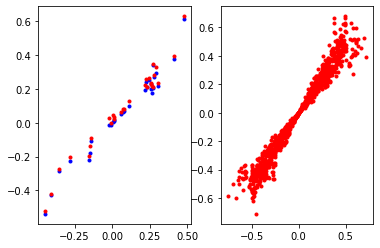

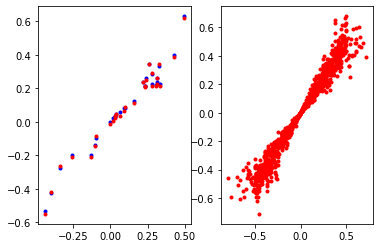

In [381]:
batch_grad_descentBPVarUpdateComp(sampled_x_train,y_train,iter, lr, midLayerSize, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff,print_op=1)